In [1]:
import glob

import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from ase.io import read as read_xyz
from dscribe.descriptors import SOAP

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data Loading

In [2]:
structures = [read_xyz(x) for x in glob.glob("../data/raw/*.xyz")]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

len(structures)

999

## Descriptive Statistics

In [3]:
print(f"Mean: {np.mean(energy_levels):.4f}")
print(f"Var : {np.var(energy_levels):.4f}")
print(f"Skew: {sp.stats.skew(energy_levels):.4f}")
print(f"Kurt: {sp.stats.kurtosis(energy_levels):.4f}")

Mean: -1551.2496
Var : 8.2602
Skew: 1.1522
Kurt: 3.2105


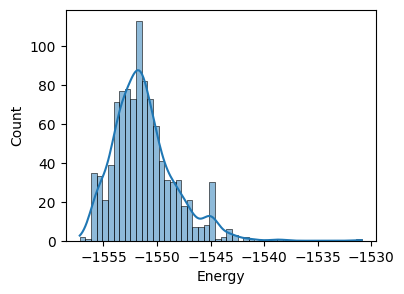

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.histplot(energy_levels, kde=True, bins=50, ax=ax)
ax.set_xlabel("Energy")

plt.show()

## SOAP Feature Extraction

In [5]:
soap = SOAP(
    # these parameters are found
    # in the soap-skyline.ipynb
    r_cut=5,
    n_max=1,
    l_max=7,
    species=["Au"],
    average="outer",
    periodic=False,
    sparse=False,
)

soap

In [6]:
X = soap.create(structures, n_jobs=2)
energy_levels_norm = MinMaxScaler().fit_transform(energy_levels.reshape(-1, 1)).flatten() * 50

X.shape, energy_levels_norm.shape

((999, 8), (999,))

## Dimensionality Reduction: PCA

In [7]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

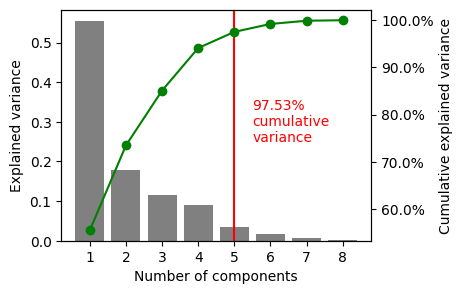

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))

pc_idx = np.arange(1, pca.explained_variance_ratio_.shape[0]+1)
pc_var_cumsum = np.cumsum(pca.explained_variance_ratio_)
pca_var_95_idx = np.argmax(pc_var_cumsum >= 0.95)

ax.bar(pc_idx, pca.explained_variance_ratio_, color="gray")
ax.axvline(pca_var_95_idx+1, c="red", label="96% variance")
ax.text(pca_var_95_idx+1.5, 0.30, f"{pc_var_cumsum[pca_var_95_idx]*100:.2f}%\ncumulative\nvariance", color="red", ha="left", va="center")
ax.set_xticks(pc_idx)
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance")

ax2 = ax.twinx()
ax2.plot(pc_idx, pc_var_cumsum, c="green", marker="o")
ax2.set_ylabel("Cumulative explained variance")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.show()

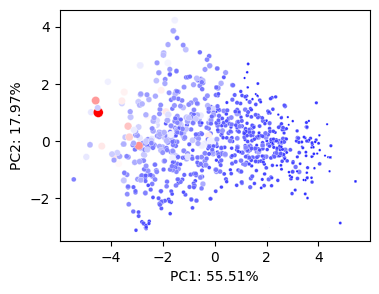

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=energy_levels_norm, c=energy_levels, cmap="bwr", ax=ax)
ax.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
ax.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

plt.show()

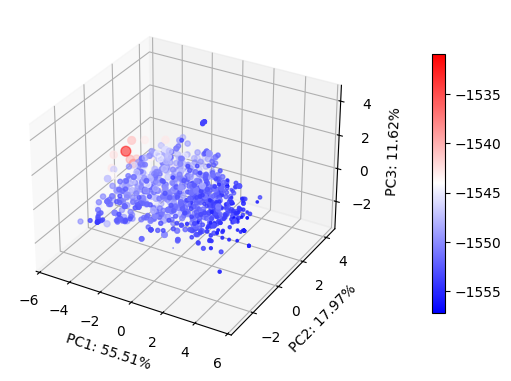

In [10]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=energy_levels_norm, c=energy_levels, cmap="bwr")

# xx, zz = np.meshgrid(np.linspace(12, -2, 20), np.linspace(-20, 20, 20))
# yy = np.meshgrid(np.linspace(-20, 40, 20), np.linspace(-20, 40, 20))[0]
# ax.plot_surface(xx, yy, zz, alpha=0.5)

ax.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
ax.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
ax.set_zlabel(f"PC3: {pca.explained_variance_ratio_[2]*100:.2f}%")

plt.colorbar(sc, shrink=0.7, pad=0.15)
plt.show()